# 0. Imports and settings

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
from skimage import data, color, exposure
from skimage.io import imread
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS = 64, 64, 3

DATA_DIR = 'data/'
LOG_DIR = 'log/'
MODELS_DIR = 'models/'
MODEL_NAME = 'cnn_cars'

# 1. Data loading

In [3]:
def print_info(x, y):
    unique, counts = np.unique(y, return_counts=True)
    print('x: {} {} \t y: {} {} \t counts: {}'.format(x.shape, x.dtype, y.shape, y.dtype, dict(zip(unique, counts))))

def get_samples(x, y, class_label, n_samples=10):
    mask = np.where(y == class_label)[0][:n_samples]
    return x[mask], y[mask]

def plot_batch(img_batch, y_true, y_pred=None, n_cols=10):
    plt.figure(figsize=(16,5))
    
    y_pred = y_true if y_pred is None else y_pred    
    n_rows = img_batch.shape[0] // n_cols + 1
    for img, true, pred, sub in zip(img_batch, y_true, y_pred, range(1, len(img_batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8))
        
        title = "{}:{:.2f}".format("car" if pred > 0 else "non-car", pred)
        pred = np.where(pred > 0, 1, -1)
        c = 'green' if true == pred else 'red'
        
        plt.title(title, color = c)
        plt.axis('off')
    plt.tight_layout()

In [4]:
cars = glob(DATA_DIR+'vehicles/*/*.png')
non_cars = glob(DATA_DIR+'non-vehicles/*/*.png')

y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

x = []
for file in cars:
    x.append(imread(file))
    
for file in non_cars:
    x.append(imread(file))
    
x = np.array(x)

print_info(x, y)

x: (17760, 64, 64, 3) uint8 	 y: (17760,) float64 	 counts: {-1.0: 8968, 1.0: 8792}


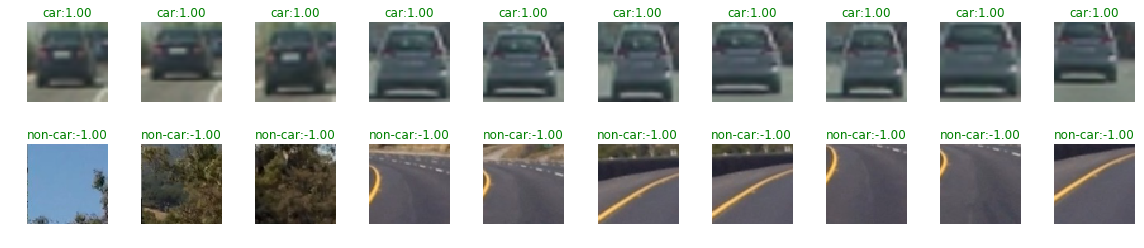

In [5]:
car_samples, car_labels = get_samples(x, y, class_label=1)
noncar_samples, noncar_labels = get_samples(x, y, class_label=-1)

samples = np.vstack((car_samples, noncar_samples))
labels = np.concatenate((car_labels, noncar_labels))
plot_batch(samples, labels)

In [6]:
# Split the dataset into training, validation, and testing
x_train, x_test, y_train, y_test = train_test_split(x.astype(np.float32), y.astype(np.float32), test_size=0.1, stratify=y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=x_test.shape[0], stratify=y_train, random_state=42)

print_info(x_train, y_train)
print_info(x_val, y_val)
print_info(x_test, y_test)

x: (14208, 64, 64, 3) float32 	 y: (14208,) float32 	 counts: {-1.0: 7174, 1.0: 7034}
x: (1776, 64, 64, 3) float32 	 y: (1776,) float32 	 counts: {-1.0: 897, 1.0: 879}
x: (1776, 64, 64, 3) float32 	 y: (1776,) float32 	 counts: {-1.0: 897, 1.0: 879}


# 2. Graph Constrution

In [7]:
tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default():
    tf_dataset = tf.placeholder(dtype=tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], name='tf_dataset')
    tf_labels = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='tf_labels')
    tf_dropout = tf.placeholder(dtype=tf.bool, name='tf_dropout')
    
    with tf.name_scope("model"):
        conv1 = tf.layers.conv2d(inputs=tf_dataset, 
                                 filters=10, 
                                 kernel_size=[3,3], 
                                 activation=tf.nn.relu, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                 padding='same', 
                                 name='conv1')
        conv2 = tf.layers.conv2d(inputs=conv1, 
                                 filters=10, 
                                 kernel_size=[3,3], 
                                 activation=tf.nn.relu, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                 padding='same', 
                                 name='conv2')
        pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[8,8], strides=[8,8])
        drop1 = tf.layers.dropout(inputs=pool1, rate=0.25, training=tf_dropout)

        dens1 = tf.layers.conv2d(inputs=drop1, 
                                 filters=128, 
                                 kernel_size=[8,8], 
                                 activation=tf.nn.relu, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                 padding='valid', 
                                 name='dense1')
        drop2 = tf.layers.dropout(inputs=dens1, rate=0.5, training=tf_dropout)
        output = tf.layers.conv2d(inputs=drop2, 
                                  filters=1, 
                                  kernel_size=[1,1], 
                                  activation=tf.nn.tanh,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  padding='valid', 
                                  name='dense2')
        
        tf.summary.histogram("output", output)
    
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.squared_difference(tf.squeeze(tf_labels), tf.squeeze(output)))
        tf.summary.scalar("loss", loss)
    
        optimizer = tf.train.AdadeltaOptimizer(learning_rate=1.0, rho=0.95, epsilon=1e-08).minimize(loss)
        
    with tf.name_scope("accuracy"):
        output = tf.squeeze(output)
        tf_pred = tf.where(output > 0, tf.ones_like(output), -1*tf.ones_like(output))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(tf_labels), tf_pred), tf.float32))*100
        tf.summary.scalar("accuracy", accuracy)


# 3. Training and Evaluation 

In [8]:
batch_size = 128
steps_by_epoch = x_train.shape[0] // batch_size
n_epochs = 2
n_steps = n_epochs * steps_by_epoch

with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    
    train_writer = tf.summary.FileWriter(logdir=LOG_DIR+'train//', graph=sess.graph)
    val_writer = tf.summary.FileWriter(logdir=LOG_DIR+'test//')
    summarize = tf.summary.merge_all()
    
    for step in range(n_steps+1):
        offset = (step*batch_size) % (x_train.shape[0] - batch_size)
        
        x_batch = x_train[offset:(offset+batch_size)]
        y_batch = y_train[offset:(offset+batch_size)].reshape(-1,1)
        
        x_batch = (x_batch/127.5)-1.0
        
        feed_dict = {tf_dataset:x_batch, tf_labels:y_batch, tf_dropout:True}        
        _, loss_batch, accuracy_batch, s = sess.run([optimizer, loss, accuracy, summarize], feed_dict=feed_dict)
        train_writer.add_summary(s, step)
        
        print('\rstep: {:=3}/{:=3} batch_loss: {:.5f} batch_accuracy: {:.2f}%'.format(step%steps_by_epoch, steps_by_epoch, loss_batch, accuracy_batch), end='')
        if step % steps_by_epoch == 0:
            feed_dict = {tf_dataset:(x_val/127.5)-1.0, tf_labels:y_val.reshape(-1,1), tf_dropout:False} 
            s, loss_val, accuracy_val = sess.run([summarize, loss, accuracy], feed_dict=feed_dict)
            val_writer.add_summary(s, step)
            
            print('\repoch: {0:=2} batch_loss: {1:.5f} batch_accuracy: {2:.2f}% val_loss: {3:.5f} val_accuracy: {4:.2f}%'.format(step//steps_by_epoch, loss_batch, accuracy_batch, loss_val, accuracy_val))

    
    feed_dict = {tf_dataset:(x_test/127.5)-1.0, tf_labels:y_test.reshape(-1,1), tf_dropout:False}
    [accuracy_test] = sess.run([accuracy], feed_dict=feed_dict)
    print('Test Accuracy: {:.2f}%'.format(accuracy_test))
    
    saver.save(sess, MODELS_DIR+MODEL_NAME)
    train_writer.close()
    val_writer.close()

epoch:  0 batch_loss: 1.30816 batch_accuracy: 48.44% val_loss: 1.11355 val_accuracy: 49.49%
epoch:  1 batch_loss: 0.33789 batch_accuracy: 88.28% val_loss: 0.35322 val_accuracy: 89.25%
epoch:  2 batch_loss: 0.16100 batch_accuracy: 96.88% val_loss: 0.15687 val_accuracy: 94.99%
Test Accuracy: 96.28%


__After training, run tensorboard with the code below:__
```sh
$ tensorboard --logdir=log
```

# 4. Restore and Testing 

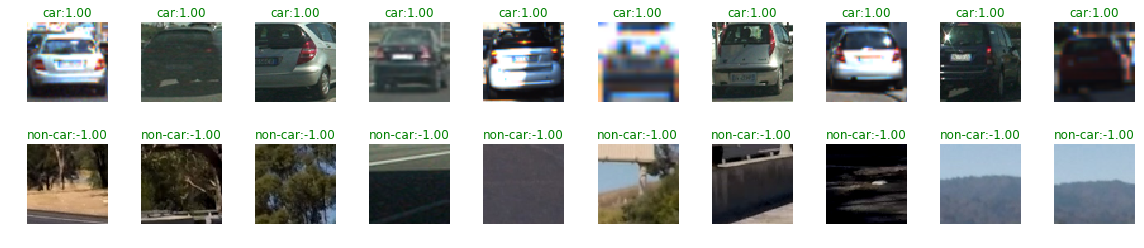

In [9]:
car_test, car_labels = get_samples(x_test, y_test, class_label=1)
noncar_test, noncar_labels = get_samples(x_test, y_test, class_label=-1)

test_batch = np.vstack((car_test, noncar_test))
test_labels = np.concatenate((car_labels, noncar_labels))

plot_batch(test_batch, test_labels, test_labels)

In [10]:
#[n.name for n in tf.get_default_graph().as_graph_def().node]

INFO:tensorflow:Restoring parameters from models/cnn_cars


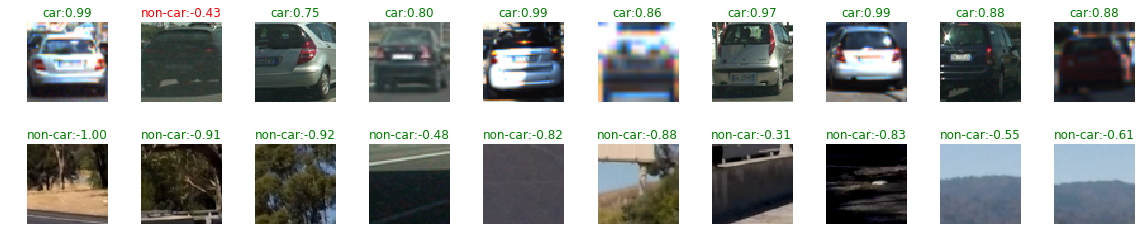

In [11]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('{}{}.meta'.format(MODELS_DIR, MODEL_NAME))
    new_saver.restore(sess, tf.train.latest_checkpoint(MODELS_DIR))
    
    graph = tf.get_default_graph()
    tf_dataset = graph.get_tensor_by_name("tf_dataset:0")
    tf_labels = graph.get_tensor_by_name("tf_labels:0")
    tf_dropout = graph.get_tensor_by_name("tf_dropout:0")
    tf_dense2 = graph.get_tensor_by_name("model/dense2/Tanh:0")
    
    feed_dict = {tf_dataset:(test_batch/127.5)-1.0, tf_labels:test_labels.reshape(-1,1), tf_dropout:False}
    [output] = sess.run([tf_dense2], feed_dict=feed_dict)
    
    plot_batch(test_batch, test_labels, np.squeeze(output))

# 5. References

- [Original Article](https://medium.com/@tuennermann/convolutional-neural-networks-to-find-cars-43cbc4fb713)
- [Original Code (in Keras)](https://github.com/HTuennermann/Vehicle-Detection-and-Tracking)
- [Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [Non-Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)
- [TensorBoard README](https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/tensorboard/README.md)
- [Hands-on Tensorboard](https://www.youtube.com/watch?v=eBbEDRsCmv4&t=1238s)
- [A quick complete tutorial to save and restore Tensorflow models](http://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/)